In [1]:
using Plots, DifferentialEquations, FFTW, SpecialFunctions

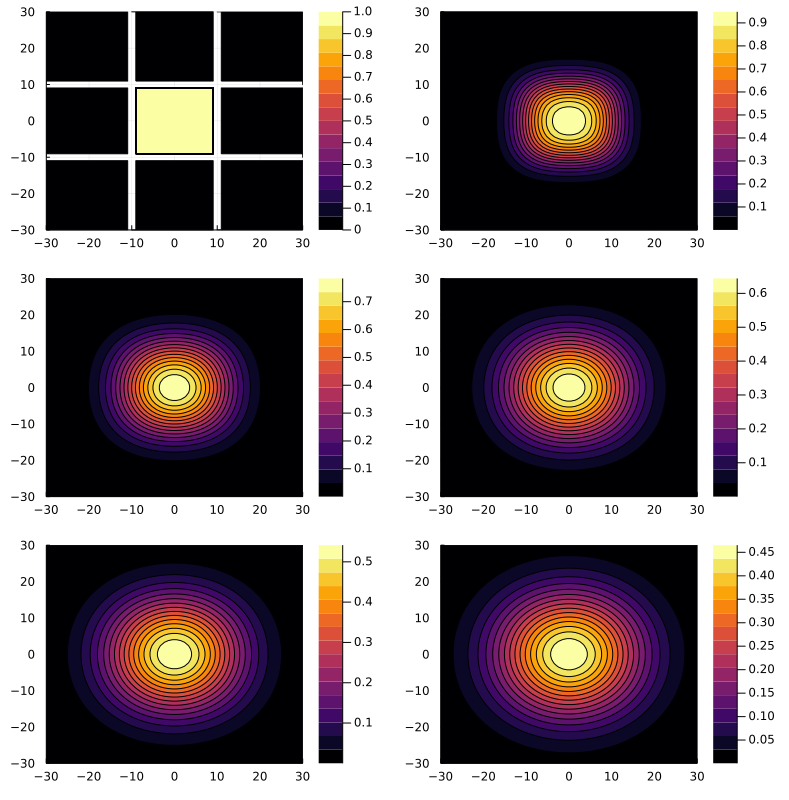

In [13]:
u_1d(x, t) = 1/2*(-erf((-10+x)/(2√t)) + erf((10+x)/(2√t)))
u_2d(x, y, t) = u_1d(x, t) * u_1d(y, t)
u_3d(x, y, z, t) = u_1d(x, t) * u_1d(y, t) * u_1d(z, t)
x = y = z = range(-30, 30, length=64)
t = range(0, 50.0, step=0.1)
p1 = contour(x, y, (x, y) -> u_2d(x, y, 0.0), fill = true)
p2 = contour(x, y, (x, y) -> u_2d(x, y, 10.0), fill = true)
p3 = contour(x, y, (x, y) -> u_2d(x, y, 20.0), fill = true)
p4 = contour(x, y, (x, y) -> u_2d(x, y, 30.0), fill = true)
p5 = contour(x, y, (x, y) -> u_2d(x, y, 40.0), fill = true)
p6 = contour(x, y, (x, y) -> u_2d(x, y, 50.0), fill = true)
plot(p1, p2, p3, p4, p5, p6, layout=(3, 2), size=(789, 800))

┌ Info: Δx = 1.0, Δy = 1.0, Δz = 1.0
└ @ Main In[16]:10


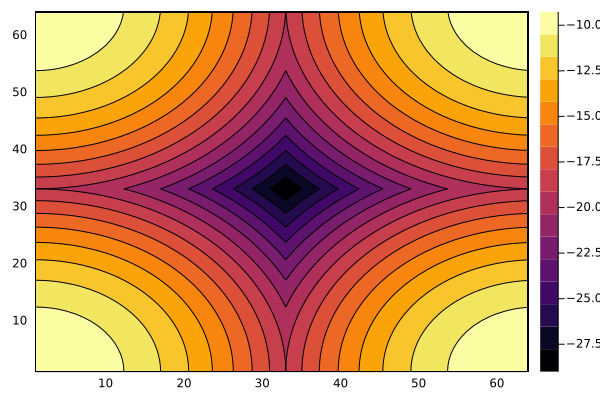

In [16]:
Lx = Ly = Lz = 64

function get_k²_3d(x, y, z)
    Lx = length(x)
    Ly = length(y)
    Lz = length(z)
    Δx = x[2] - x[1]
    Δy = y[2] - y[1]
    Δz = z[2] - z[1]
    @info "Δx = $Δx, Δy = $Δy, Δz = $Δz"
    k² = zeros(Lx, Ly, Lz)
    fx = 2π/(Δx*Lx)
    fy = 2π/(Δy*Ly)
    fz = 2π/(Δz*Lz)
    kx² = zeros(Lx)
    ky² = zeros(Ly)
    kz² = zeros(Lz)
    for i=0:(Lx-1)
        kx²[i+1] = i < Lx/2 ? (i*fx)^2 : ((i-Lx)*fx)^2
    end
    for j=0:(Ly-1)
        ky²[j+1] = j < Ly/2 ? (j*fy)^2 : ((j-Ly)*fy)^2
    end
    for k=0:(Lz-1)
        kz²[k+1] = k < Lz/2 ? (k*fz)^2 : ((k-Lz)*fz)^2
    end
    for i=1:Lx
        for j=1:Ly
            for k=1:Lz
                k²[i,j,k] = kx²[i] + ky²[j] + kz²[k]
            end
        end
    end
    return -k²
end

x = collect(range(-32, 31, length=Lx))
y = collect(range(-32, 31, length=Ly))
z = collect(range(-32, 31, length=Lz))
k² = get_k²_3d(x, y, z)
contourf(k²[:,:,32])

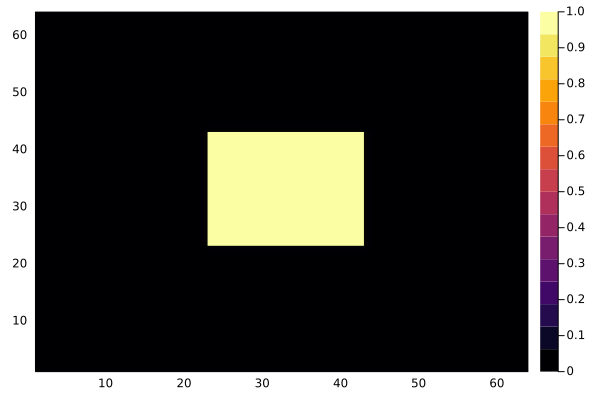

In [34]:
function f(u, k², t)
    return real(ifft(k².*fft(u)))
end

u0 = [(abs(xᵢ) <= 10.0)*(abs(yᵢ) <= 10.0)*(abs(zᵢ) <= 10.0) for xᵢ in x, yᵢ in y, zᵢ in z] .* 1.0
contourf(u0[:,:,32])

Without DifferentialEquations.jl

In [18]:
function implicit()
    t = [0.0]
    sol = Array{Float64, 3}[u0]
    Δt = 0.1
    L = @. 1.0 / (1.0 - Δt*k²)
    while t[end] <= 50.0
        push!(sol, real(ifft(L .* fft(sol[end]))))
        push!(t, t[end] + Δt)
    end
    return t, sol
end

t, sol = implicit();

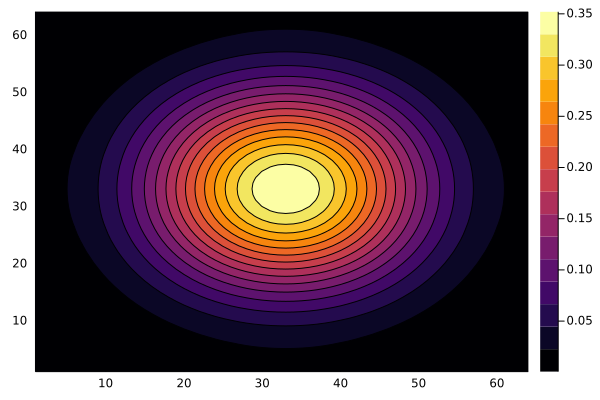

In [19]:
contourf(sol[end][:,:,32])

In [20]:
xc = div(Lx, 2)+1
yc = div(Ly, 2)+1
zc = div(Lz, 2)+1
x[xc], y[yc], z[zc]

(0.0, 0.0, 0.0)

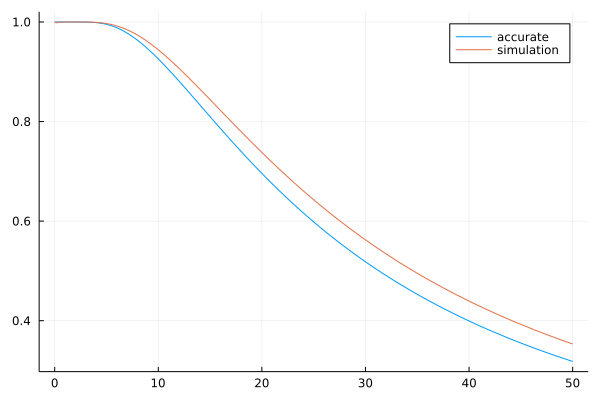

In [21]:
u_c = [sol[i][xc, yc, zc] for i in 1:length(t)]
p = plot()
plot!(t, u_3d.(0.0, 0.0, 0.0, t), label="accurate")
plot!(t, u_c, label="simulation")

## Comparison to HeFFTe

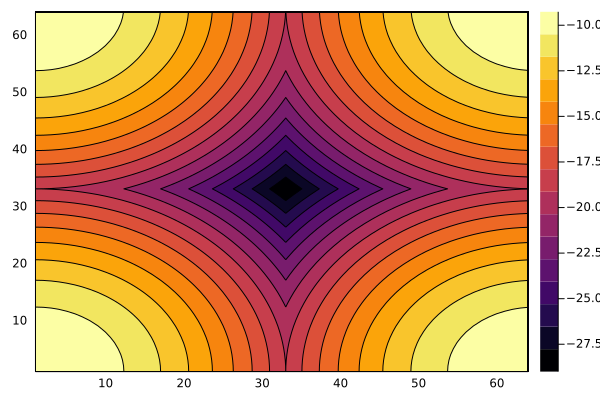

In [25]:
k²_h = similar(k²)
io = open("k2.bin", "r")
read!(io, k²_h)
close(io)
contourf(k²_h[:,:,32])

In [26]:
isapprox(k², k²_h)

true

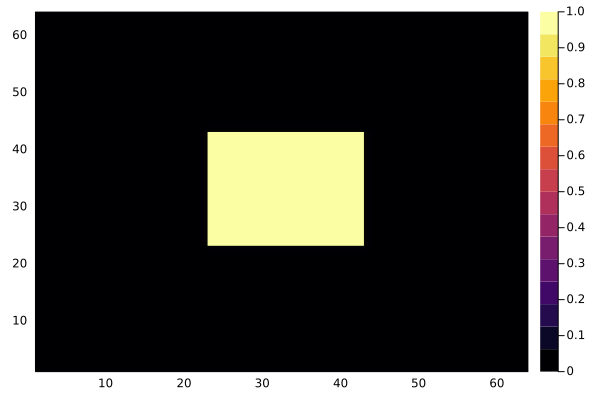

In [35]:
u0_h = similar(u0)
io = open("u0.bin", "r")
read!(io, u0_h)
close(io)
contourf(u0_h[:,:,32])

In [39]:
isapprox(u0, u0_h)

true

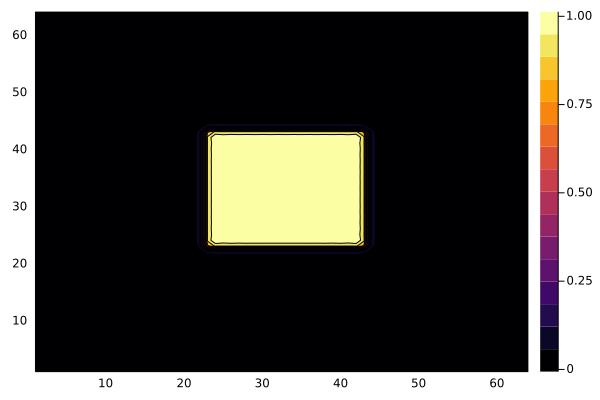

In [40]:
u1 = sol[2]
contourf(u1[:,:,32])

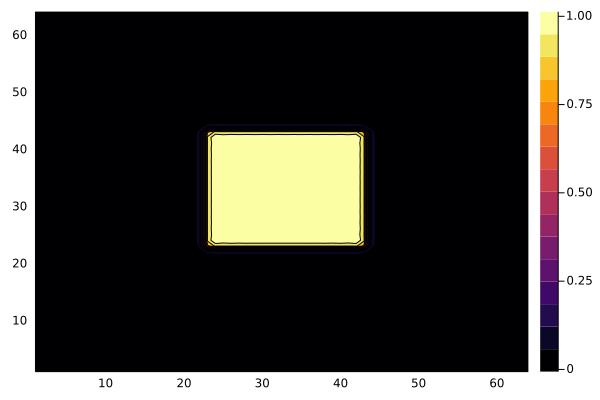

In [45]:
u1_h = similar(u1)
io = open("u1.bin", "r")
read!(io, u1_h)
close(io)
contourf(u1_h[:,:,32])

In [46]:
isapprox(u1, u1_h)

true

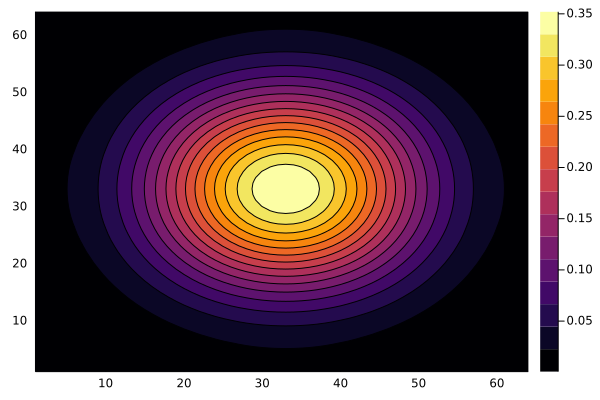

In [47]:
u500 = sol[end]
u500_h = similar(u500)
io = open("u500.bin", "r")
read!(io, u500_h)
close(io)
contourf(u500_h[:,:,32])

In [48]:
isapprox(u500, u500_h)

true

In [51]:
using DataFrames, CSV

In [55]:
df = DataFrame(CSV.File("data.csv"));

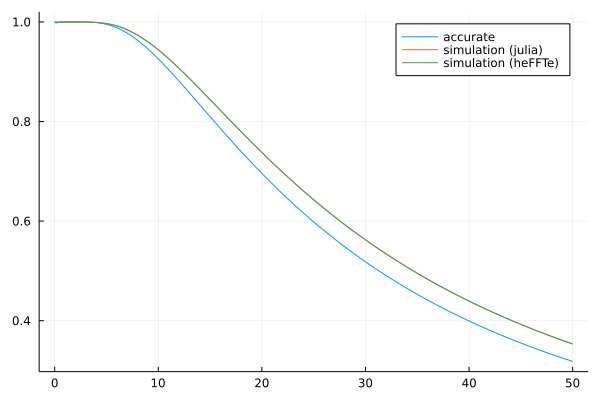

In [58]:
u_c = [sol[i][xc, yc, zc] for i in 1:length(t)]
p = plot()
plot!(t, u_3d.(0.0, 0.0, 0.0, t), label="accurate")
plot!(t, u_c, label="simulation (julia)")
plot!(df.t, df.u, label="simulation (heFFTe)")